In [ ]:
%%capture
!pip3 install torch --extra-index-url https://download.pytorch.org/whl/cu116
!pip3 install rdkit
!pip3 install git+https://github.com/molecularsets/moses.git

In [ ]:
import sys
import os

import torch
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, DataStructs
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random

torch.cuda.set_device(0)

/usr/local/lib/python3.10/dist-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sys.path.insert(1, "/content/gdrive/My Drive/GENTRL-private")
import gentrl_v2

In [ ]:
os.chdir('/content/gdrive/My Drive/GENTRL-private')

In [ ]:
experts = pd.read_csv('./data/canonized/esr1.csv')
expert_smiles = experts['SMILES'].tolist()

In [ ]:
len(expert_smiles)

384

In [ ]:
from rdkit.Chem import QED, Descriptors, RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

from moses.utils import disable_rdkit_log
disable_rdkit_log()

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])

# added QED to favor molecules with high predicted bioactivity
def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = Descriptors.MolLogP(mol) - sascorer.calculateScore(mol) - get_num_rings_6(mol) + QED.qed(mol)
    #reward = Descriptors.MolLogP(mol) - sascorer.calculateScore(mol) + QED.qed(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [ ]:
LATENT_SIZE = 8
LATENT_DESC = LATENT_SIZE * [('c', 10)]
# 1 chemical property (y) used
FEATURE_DESC = [('c', 10), ('c', 10), ('d', 3), ('c', 10)]
BETA = 0.001
GAMMA = 0.25
BATCH_SIZE = 128
EXPERIMENT_NAME = '012_biased_vae_rnn_50k'

In [ ]:
enc = gentrl_v2.RNNEncoder(latent_size=LATENT_SIZE, bidirectional=True, hidden_size=128)
dec = gentrl_v2.RNNDecoder(latent_input_size=LATENT_SIZE)
model = gentrl_v2.GENTRL(enc, dec, LATENT_DESC, FEATURE_DESC,  beta=BETA, gamma=GAMMA, state_dim=LATENT_SIZE, action_dim=8)
model.cuda();

In [ ]:
# Select a model to sample from
path_part = EXPERIMENT_NAME+'/IL3_5/40000'
model.load('models/'+path_part)
model.cuda();

In [ ]:
# Sample only valid SMILES
generated = []

while len(generated) < 1000:
    sampled = model.sample(100)
    sampled_valid = [s for s in sampled if get_mol(s)]

    generated += sampled_valid

In [ ]:
len(set(generated))

985

In [ ]:
# Sample valid and invalid SMILES
generated_all = model.sample(1000)

In [ ]:
# Save sampled SMILES
pd.DataFrame(generated_all).to_csv('./data/sampled_data/'+path_part+'_all.csv', index=False)

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


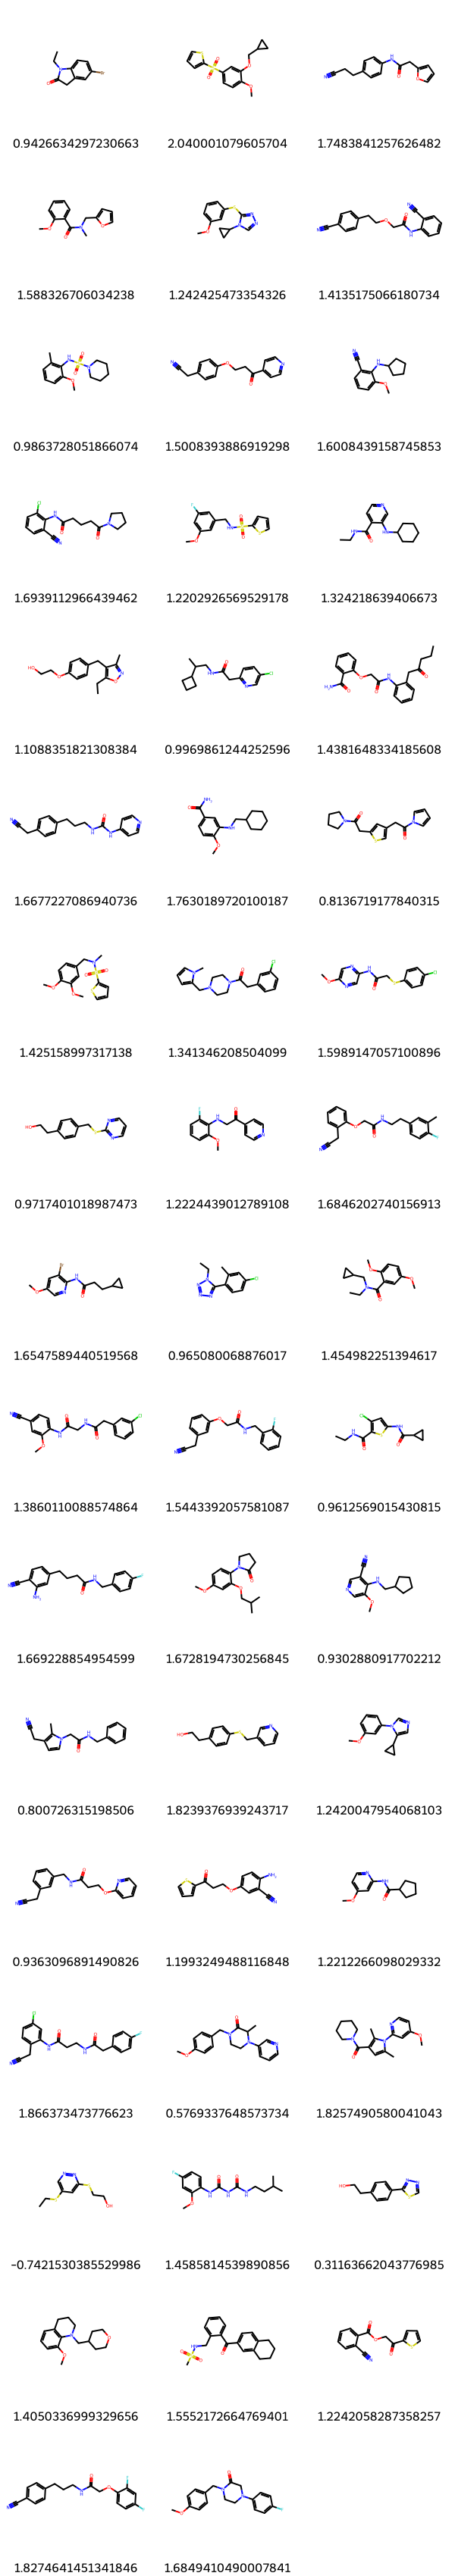

In [ ]:
# Visualise sampled SMILES
Draw.MolsToGridImage([get_mol(s) for s in sampled_valid],
                     legends=[str(penalized_logP(s)) for s in sampled_valid])